In [1]:
%matplotlib inline
import tensorflow as tf
import keras as k
from keras import layers
from keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import sys

In [26]:
img = Image.open("melanoma.jpg")
img = img.resize((256,256))
img = np.array(img)
img.shape


(256, 256, 3)

In [17]:
#ensure u have the right jupyter notebook version
print(sys.version_info)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)


In [24]:
#data manip
"""
df1 = x
df2 = y
df1.merge(df2, how = 'a', on = ['b', 'c'])
    #Renaming Series for merging
df1.rename(
    columns={"OLD COLUMN NAME": "NEW COLUMN NAME", "OLD COLUMN NAME 2": "NEW COLUMN NAME 2"},
    inplace=True,
)
"""

'\ndf1 = x\ndf2 = y\ndf1.merge(df2, how = \'a\', on = [\'b\', \'c\'])\n    #Renaming Series for merging\ndf1.rename(\n    columns={"OLD COLUMN NAME": "NEW COLUMN NAME", "OLD COLUMN NAME 2": "NEW COLUMN NAME 2"},\n    inplace=True,\n)\n'

In [8]:
#image data generator
datagen = ImageDataGenerator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(250, 250, 3)


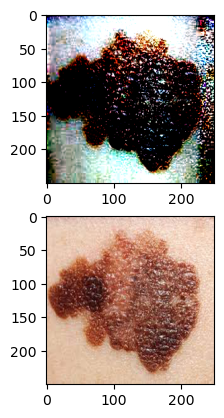

In [71]:
"""
layer = layers.Normalization(input_size=[250,250])
layer.adapt(img)
layer(img)
"""

def standardize(image):
    standardized_image = np.zeros(image.shape)
    for c in range(image.shape[0]):
        for z in range(image.shape[3]):
            image_slice = image[c,:,:,z]
            centered = image_slice-np.mean(image_slice)
            if np.std(centered) != 0:
                centered_scaled = centered/np.std(centered)
            standardized_image[c, :, :, z] = centered_scaled
    return standardized_image
"""
layer = layers.Normalization()
layer.adapt(data)
normalized_data = layer(data)
"""
norm = (img - np.mean(img, axis=0))/np.std(img, axis=0) #deep fry the image!!
#norm = (img - np.min(img)) / (np.max(img) - np.min(img))
print(norm.shape)
#norm = standardize(img)
f, axarr = plt.subplots(2)
axarr[0].imshow(norm)#, interpolation='nearest')
axarr[1].imshow(img)#, interpolation='nearest')

In [6]:
foo = 64
#data = None #set data to this value
#train_ds, test_ds = tf.keras.utils.split_dataset(data, left_size=0.8) #SPLIT DATASET --> COMBINE ALL DATA INTO ONE VARIABLE AND THIS WILL SPLIT IT
#class_num = data.shape()-2 #number of unique labels in data
"""
import cv2
import os

def load_folder_imgs(folder):
    images = []
    for filenm in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(np.array(img))
    return images
"""
#In ISIC2018, task 3 is for full identification, task 1 is segmentation

#identification datasets
#train_ds_X = load_folder_imgs("C:/foldername") 
#valid_ds_X = load_folder_imgs("C:/foldername") 
#train_ds_y = load_folder_imgs("C:/foldername")
#valid_ds_y = load_folder_imgs("C:/foldername")

#segmentation datasets
#train_gt_X = load_folder_imgs("C:/foldername")
#valid_gt_X = load_folder_imgs("C:/foldername")
#train_gt_y = load_folder_imgs("C:/foldername")
#valid_gt_y = load_folder_imgs("C:/foldername")

#include test data?

#train_ds_y #these are the answers (from the .csv)

#https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
U_Net = Sequential()
#change later
#data augmentation
"""
model = k.layers.RandomContrast(factor=0.1)(model)
model = k.layers.RandomFlip()(model) #horizontal and vertical flipping
model = k.layers.RandomRotation(factor=0.1)(model)
"""
U_Net.add(layers.Conv2D(filters=foo, kernel_size=3, padding="same", input_shape=(256,256,3)))
U_Net.add(layers.BatchNormalization())
#(x) --> using previous layer as input for next layer
U_Net.add(layers.Activation("relu"))

for filter in [64,128,256]:
    U_Net.add(layers.Conv2D(filters=filter, kernel_size=3, padding="same",activation="relu")) # (filters, kernel_size, padding, activation)
    U_Net.add(layers.BatchNormalization())

    U_Net.add(layers.Conv2D(filter, 3, padding="same",activation="relu"))
    U_Net.add(layers.BatchNormalization())

    U_Net.add(layers.MaxPooling2D(3, strides=2, padding="same")) # (pool_size, strides, padding)

#expanding u-net

for filter in [256, 128, 64]:
    U_Net.add(layers.Conv2DTranspose(filter, 3, padding="same",activation="relu"))
    U_Net.add(layers.BatchNormalization())

    U_Net.add(layers.Conv2DTranspose(filter, 3, padding="same",activation="relu"))
    U_Net.add(layers.BatchNormalization())
    U_Net.add(layers.UpSampling2D(2))

classification = Sequential([
    layers.Conv2D(7, kernel_size=3, activation="softmax", padding="same", input_shape=(256,256,3))
])
classification.summary()
#first input is # of classes

model = Sequential([
    U_Net,
    classification
])
model.summary()

#model_final = tf.keras.Model(data, classification)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)                 │ (None, 256, 256, 7)           │         196 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 196 (784.00 B)

 Trainable params: 196 (784.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)          │ ?                             │   2,923,264 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ sequential_10 (Sequential)         │ ?                             │         196 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 2,923,460 (11.15 MB)

 Trainable params: 2,919,748 (11.14 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [ ]:
#train U-net on ground truth
classification.trainable = False
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["binary_accuracy"]) # we can actually use metrics without matplotlib!!!! woww!!! i think

callback_list = [tf.keras.callbacks.EarlyStopping(patience=2)] #can adjust to improve accuracy

#early stopping used to prevent overfitting

model.fit(x=train_gt_X, y=train_gt_y epochs=10, callbacks=callback_list, verbose=2)



In [ ]:
#validation gt
model.predict(valid_gt, verbose=0, batch_size=128, steps=2)


In [ ]:
#train classification w/ U_net on full images
U_Net.trainable = False
classification.trainable = True

model.fit(x=train_ds_X, y=train_ds_y, epochs=10, batch_size=train_ds.length, callbacks=callback_list, verbose=2)

In [ ]:
#validation full

model.predict(valid_ds, verbose=0, batch_size=128, steps=2)


(256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
(128, 128, 3)
<class 'numpy.ndarray'>


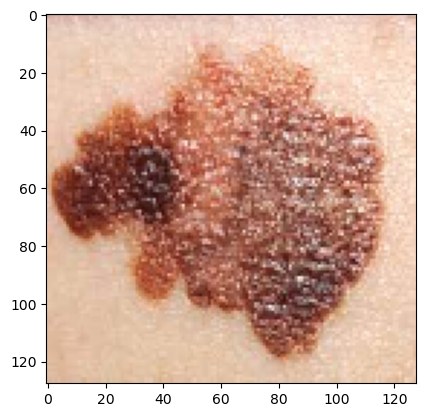

In [64]:
img = Image.open("melanoma.jpg")
img = img.resize((256,256))
plt.imshow(img)
img = np.array(img)


test = Sequential([
    layers.InputLayer(shape=(256,256,3)),
    layers.MaxPooling2D(pool_size=(2,2))
])

test.compile('adam', 'binary_cross_entropy')
print(img.shape)
img2 = np.expand_dims(img, 0)

res = test.predict(img2, steps=1)
res.shape
res2 = res[0,:,:,:]
print(res2.shape)
plt.imshow((res2).astype(np.uint8)) # *255 to negative??
#plt.imshow(img)
print(type(res2[0][0]))

In [ ]:
#compilation code here
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["binary_accuracy"]) # we can actually use metrics without matplotlib!!!! woww!!! i think

callback_list = [tf.keras.callbacks.EarlyStopping(patience=2)] #can adjust to improve accuracy

#early stopping used to prevent overfitting

model.fit(train_ds, epochs=10, callbacks=callback_list)